In [1]:
# imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
import pandas as pd

# data cleaning
# arbeitslosenquote
arbeitslosenquote = pd.read_csv(
    "./original data/Arbeitslosenquote.csv", sep=";", decimal=","
)

cols_to_clean_dots = ["Bestand Arbeitslose", "Zugang Arbeitslose", "Abgang Arbeitslose"]
for col in cols_to_clean_dots:
    arbeitslosenquote[col] = (
        arbeitslosenquote[col]
        .astype(str)
        .str.replace(".", "", regex=False)
        .replace("", "0")
        .astype(int)
    )

arbeitslosenquote["Arbeitslosenquote"] = (
    arbeitslosenquote["Arbeitslosenquote"]
    .astype(str)
    .str.replace(",", ".", regex=False)
    .replace("", "0")
    .astype(float)
)

month_map = {
    "Januar": "01",
    "Februar": "02",
    "März": "03",
    "April": "04",
    "Mai": "05",
    "Juni": "06",
    "Juli": "07",
    "August": "08",
    "September": "09",
    "Oktober": "10",
    "November": "11",
    "Dezember": "12",
}

def convert_to_date(berichtsmonat_str):
    try:
        month_name, year_str = berichtsmonat_str.split(" ")
        month_num = month_map.get(month_name)
        return f"{year_str}-{month_num}-01"
    except Exception:
        return pd.NaT


arbeitslosenquote["DATE"] = (
    arbeitslosenquote["Berichtsmonat"].astype(str).apply(convert_to_date)
)
arbeitslosenquote["DATE"] = pd.to_datetime(arbeitslosenquote["DATE"], errors="coerce")
arbeitslosenquote["DATE"] = arbeitslosenquote["DATE"] + pd.offsets.MonthEnd(0)

arbeitslosenquote = arbeitslosenquote.drop(columns=["Berichtsmonat"])
cols_order = ["DATE"] + [col for col in arbeitslosenquote.columns if col != "DATE"]
arbeitslosenquote = arbeitslosenquote[cols_order]

# IFO beschaeftigungsbarometer
beschaeftigungsbarometer = pd.read_csv("./original data/IFO_Beschäftigungsbarometer.csv")
beschaeftigungsbarometer["DATE"] = pd.to_datetime(beschaeftigungsbarometer["DATE"], errors="coerce") + pd.offsets.MonthEnd(0)
beschaeftigungsbarometer["DATE"] = beschaeftigungsbarometer["DATE"].dt.strftime("%Y-%m-%d")

# IFO geschäftsklima
geschaeftsklima = pd.read_csv("./original data/IFO_Geschäftsklima.csv")
# Strip whitespace from the DATE column
geschaeftsklima["DATE"] = geschaeftsklima["DATE"].str.strip()
# Convert "DATE" from MM/YYYY to YYYY-MM-DD (set to last day of month)
geschaeftsklima["DATE"] = pd.to_datetime("01/" + geschaeftsklima["DATE"], format="%d/%m/%Y") + pd.offsets.MonthEnd(0)
geschaeftsklima["DATE"] = geschaeftsklima["DATE"].dt.strftime("%Y-%m-%d")
geschaeftsklima["DATE"] = pd.to_datetime(geschaeftsklima["DATE"], errors="coerce") + pd.offsets.MonthEnd(0)
geschaeftsklima["DATE"] = geschaeftsklima["DATE"].dt.strftime("%Y-%m-%d")

# bmw absatzzahlen
bmw_absatzzahlen = pd.read_csv("./original data/BMW_Absatzzahlen.csv")
bmw_absatzzahlen["DATE"] = pd.to_datetime(bmw_absatzzahlen["DATE"], errors="coerce") + pd.offsets.MonthEnd(0)
bmw_absatzzahlen["DATE"] = bmw_absatzzahlen["DATE"].dt.strftime("%Y-%m-%d")

# # bruttoinlandsprodukt
# bruttoinlandsprodukt = pd.read_csv("./original data/Bruttoinlandsprodukt.csv", sep=";", decimal=",")
# # Remove specified columns
# bruttoinlandsprodukt = bruttoinlandsprodukt.drop([
#   "in jeweiligen Preisen, Mrd. EUR, saison- und kalenderbereinigte Werte nach X13 JDemetra+",
#   "preisbereinigt, Kettenindex (2020=100), saison- und kalenderbereinigte Werte nach X13 JDemetra+"
# ], axis=1)
# # Convert "Datum" to "DATE" in YYYY-MM-DD format (set to last day of quarter)
# bruttoinlandsprodukt["DATE"] = pd.to_datetime(bruttoinlandsprodukt["Datum"], format="%d/%m/%Y") + pd.offsets.MonthEnd(0)
# bruttoinlandsprodukt["DATE"] = bruttoinlandsprodukt["DATE"].dt.strftime("%Y-%m-%d")

# # Convert "Datum" to "DATE" in YYYY-MM-DD format
# bruttoinlandsprodukt["DATE"] = pd.to_datetime(bruttoinlandsprodukt["Datum"], format="%d/%m/%Y").dt.strftime("%Y-%m-%d")
# bruttoinlandsprodukt = bruttoinlandsprodukt.drop(columns=["Datum"])

# # Reorder columns to have "DATE" first
# cols = ["DATE"] + [col for col in bruttoinlandsprodukt.columns if col != "DATE"]
# bruttoinlandsprodukt = bruttoinlandsprodukt[cols]
# bruttoinlandsprodukt = bruttoinlandsprodukt.rename(columns={
#   "in jeweiligen Preisen, Mrd. EUR, Originalwert": "BIP",
#   "preisbereinigt, Kettenindex (2020=100), Originalwert": "BIP preisbereinigt"
# })

# euribor
euribor_1y = pd.read_csv("./original data/Euribor_1Y.csv", sep=",", decimal=".")

# Convert DATE column to datetime (assuming format is YYYY-MM-DD)
euribor_1y["DATE"] = pd.to_datetime(euribor_1y["DATE"], format="%Y-%m-%d", errors="coerce")
euribor_1y["DATE"] = euribor_1y["DATE"] + pd.offsets.MonthEnd(0)
euribor_1y["DATE"] = euribor_1y["DATE"].dt.strftime("%Y-%m-%d")

euribor_1y = euribor_1y.rename(
    columns={
        "Euribor 1-year - Historical close, average of observations through period (FM.M.U2.EUR.RT.MM.EURIBOR1YD_.HSTA)": "Euribor 1Y"
    }
)
euribor_1y = euribor_1y.drop(columns=["TIME PERIOD"])

euribor_3m = pd.read_csv("./original data/Euribor_3M.csv", sep=",", decimal=".")
# Convert DATE column to datetime (assuming format is YYYY-MM-DD)
euribor_3m["DATE"] = pd.to_datetime(euribor_3m["DATE"], format="%Y-%m-%d", errors="coerce")
euribor_3m["DATE"] = euribor_3m["DATE"] + pd.offsets.MonthEnd(0)
euribor_3m["DATE"] = euribor_3m["DATE"].dt.strftime("%Y-%m-%d")
euribor_3m = euribor_3m.rename(
    columns={
        "Euribor 3-month - Historical close, average of observations through period (FM.M.U2.EUR.RT.MM.EURIBOR3MD_.HSTA)": "Euribor 3M"
    }
)
euribor_3m = euribor_3m.drop(columns=["TIME PERIOD"])

euribor_6m = pd.read_csv("./original data/Euribor_6M.csv", sep=",", decimal=".")
# Convert DATE column to datetime (assuming format is YYYY-MM-DD)
euribor_6m["DATE"] = pd.to_datetime(euribor_6m["DATE"], format="%Y-%m-%d", errors="coerce")
euribor_6m["DATE"] = euribor_6m["DATE"] + pd.offsets.MonthEnd(0)
euribor_6m["DATE"] = euribor_6m["DATE"].dt.strftime("%Y-%m-%d")
euribor_6m = euribor_6m.rename(
    columns={
        "Euribor 6-month - Historical close, average of observations through period (FM.M.U2.EUR.RT.MM.EURIBOR6MD_.HSTA)": "Euribor 6M"
    }
)
euribor_6m = euribor_6m.drop(columns=["TIME PERIOD"])


# gebrauchtwagenpreisindex
gebrauchtwagenpreisindex = pd.read_csv("./original data/Gebrauchtwagenpreisindex.csv")
gebrauchtwagenpreisindex["DATE"] = pd.to_datetime(gebrauchtwagenpreisindex["DATE"], errors="coerce") + pd.offsets.MonthEnd(0)
gebrauchtwagenpreisindex["DATE"] = gebrauchtwagenpreisindex["DATE"].dt.strftime("%Y-%m-%d")

# google trends
gt_auto_finanzierung = pd.read_csv("./original data/GT_Auto_Finanzierung.csv")
gt_auto_leasing = pd.read_csv("./original data/GT_Auto_Leasing.csv")
gt_bmw_finanzierung = pd.read_csv("./original data/GT_BMW_Finanzierung.csv")
gt_bmw_leasing = pd.read_csv("./original data/GT_BMW_Leasing.csv")
gt_bmw = pd.read_csv("./original data/GT_BMW.csv")

# Convert "Monat" columns in Google Trends data to "DATE" in YYYY-MM-DD format (set to last day of month)
def convert_monat_to_date(df, monat_col="DATE"):
  df["DATE"] = pd.to_datetime(df[monat_col] + "-01", format="%Y-%m-%d") + pd.offsets.MonthEnd(0)
  df["DATE"] = df["DATE"].dt.strftime("%Y-%m-%d")
  return df

gt_auto_finanzierung = convert_monat_to_date(gt_auto_finanzierung)
gt_auto_leasing = convert_monat_to_date(gt_auto_leasing)
gt_bmw_finanzierung = convert_monat_to_date(gt_bmw_finanzierung)
gt_bmw_leasing = convert_monat_to_date(gt_bmw_leasing)
gt_bmw = convert_monat_to_date(gt_bmw)

# verbraucherpreisindex
verbraucherpreisindex = pd.read_csv("./original data/Verbraucherpreisindex.csv", sep=";", decimal=",")

# Columns to clean: replace comma with period and convert to float
cols_to_clean_comma = [
    "Index der Erzeugerpreise gewerblicher Produkte",
    "Index der Einfuhrpreise",
    "Index der Ausfuhrpreise"
]

for col in cols_to_clean_comma:
    verbraucherpreisindex[col] = (
        verbraucherpreisindex[col]
        .astype(str)
        .str.replace(",", ".", regex=False)
        .replace(".", "0", regex=False)  # Handle cases where only a period might be left or as a placeholder
        .replace("", "0") # Replace empty strings with 0
        .astype(float)
    )

# Convert "Datum" to datetime, then set to last day of month
verbraucherpreisindex["DATE"] = pd.to_datetime(verbraucherpreisindex["Datum"], format="%d/%m/%Y") + pd.offsets.MonthEnd(0)
verbraucherpreisindex["DATE"] = verbraucherpreisindex["DATE"].dt.strftime("%Y-%m-%d")
verbraucherpreisindex = verbraucherpreisindex.drop(columns=["Datum"])
cols = ["DATE"] + [col for col in verbraucherpreisindex.columns if col != "DATE"]
verbraucherpreisindex = verbraucherpreisindex[cols]



In [ ]:
# Merge all dataframes on "DATE"

# List of all DataFrames to merge
from functools import reduce


dfs = [
    bmw_absatzzahlen,
    gt_auto_leasing,
    gt_auto_finanzierung,
    gt_bmw_leasing,
    gt_bmw_finanzierung,
    gt_bmw,
    euribor_3m,
    euribor_6m,
    euribor_1y,
    gebrauchtwagenpreisindex,
    arbeitslosenquote,
    beschaeftigungsbarometer,
    geschaeftsklima,
    verbraucherpreisindex
]

# Ensure all DATE columns are in datetime format
for df_item in dfs:
    if "DATE" in df_item.columns:
        df_item["DATE"] = pd.to_datetime(df_item["DATE"])

# Full outer join on the DATE column for all DataFrames
merged = reduce(lambda left, right: pd.merge(left, right, on="DATE", how="outer"), dfs)
merged.to_csv("./cleaned data/all_data.csv", index=False)
merged

,DATE,SALES,Auto Leasing,Auto Finanzierung,BMW Leasing,BMW Finanzierung,BMW,Euribor 3M,Euribor 6M,Euribor 1Y,...,Geschäftsklima,Geschäftslage,Geschäftserwartungen,Konjunkturampel,Verbraucherpreisindex,Index der Einzelhandelspreise,Index der Erzeugerpreise gewerblicher Produkte,Index der Growsshandelsverkaufspreise,Index der Einfuhrpreise,Index der Ausfuhrpreise
0,1994-01-31,NaN,NaN,NaN,NaN,NaN,NaN,6.9100,6.6700,6.3400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1994-02-28,NaN,NaN,NaN,NaN,NaN,NaN,6.8600,6.6800,6.4200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1994-03-31,NaN,NaN,NaN,NaN,NaN,NaN,6.7500,6.6500,6.5500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1994-04-30,NaN,NaN,NaN,NaN,NaN,NaN,6.5700,6.5100,6.4600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1994-05-31,NaN,NaN,NaN,NaN,NaN,NaN,6.2400,6.2100,6.2500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,2025-01-31,13541.0,67.0,93.0,80.0,65.0,23.0,2.7031,2.6121,2.5221,...,85.2,86.0,84.3,26.9,120.3,122.8,128.2,117.4,115.2,116.3
373,2025-02-28,12601.0,75.0,100.0,85.0,67.0,24.0,2.5249,2.4596,2.4069,...,85.3,85.0,85.6,30.2,120.8,123.1,128.0,118.1,115.5,116.7
374,2025-03-31,14930.0,72.0,94.0,96.0,68.0,27.0,2.4424,2.3854,2.3984,...,86.7,85.7,87.7,69.9,121.2,123.7,127.1,117.9,114.3,116.2
375,2025-04-30,16113.0,65.0,96.0,85.0,68.0,26.0,2.2482,2.2010,2.1424,...,86.9,86.4,87.4,70.6,121.7,123.9,0.0,117.8,0.0,0.0


In [29]:
# descriptive statistics
df = pd.read_csv('./cleaned data/all_data.csv')
df.columns = df.columns.str.strip()  # Strip whitespace from column names


df_ds = df.describe()
df_ds = df_ds.transpose()
df_ds

,count,mean,std,min,25%,50%,75%,max
SALES,124.0,1.839033e+04,3214.064116,1.091300e+04,1.576900e+04,1.857150e+04,2.084350e+04,25536.00
Auto Leasing,125.0,4.868800e+01,16.397982,2.400000e+01,3.700000e+01,4.500000e+01,6.100000e+01,100.00
Auto Finanzierung,125.0,6.879200e+01,11.744797,4.200000e+01,6.200000e+01,6.600000e+01,7.400000e+01,100.00
BMW Leasing,125.0,7.068000e+01,11.457214,4.600000e+01,6.100000e+01,7.000000e+01,8.000000e+01,100.00
BMW Finanzierung,125.0,6.133600e+01,13.619213,3.900000e+01,5.100000e+01,5.900000e+01,7.100000e+01,100.00
BMW,125.0,2.397600e+01,7.334699,1.800000e+01,2.100000e+01,2.400000e+01,2.500000e+01,100.00
Euribor 3M,376.0,2.255088e+00,2.170576,-5.820000e-01,9.347500e-02,2.145850e+00,3.937325e+00,7.58
Euribor 6M,376.0,2.343862e+00,2.146820,-5.446000e-01,2.687750e-01,2.195750e+00,4.002225e+00,7.74
Euribor 1Y,376.0,2.472024e+00,2.137245,-5.047000e-01,4.801250e-01,2.331550e+00,4.106000e+00,8.02
Gebrauchtwagenpreisindex,124.0,1.267952e+02,18.987954,1.000000e+02,1.100750e+02,1.185500e+02,1.396250e+02,171.60


In [31]:
# seasonal adjustment
# data by IFO-Institut already seasonally adjusted

from statsmodels.tsa.seasonal import STL
# List of columns to be seasonally adjusted
seasonal_cols = [
    "SALES",
    "Auto Leasing",
    "Auto Finanzierung",
    "BMW Leasing",
    "BMW Finanzierung",
    "BMW",
    "Gebrauchtwagenpreisindex",
    "Bestand Arbeitslose",
    "Zugang Arbeitslose",
    "Abgang Arbeitslose",
    "Arbeitslosenquote",
    "Verbraucherpreisindex",
    "Index der Einzelhandelspreise",
    "Index der Erzeugerpreise gewerblicher Produkte",
    "Index der Growsshandelsverkaufspreise",
    "Index der Einfuhrpreise",
    "Index der Ausfuhrpreise",
]

df_sa = df.copy()
df_sa["DATE"] = pd.to_datetime(df_sa["DATE"])
df_sa = df_sa.set_index("DATE")

for col in seasonal_cols:
    if col in df_sa.columns:
        series = df_sa[col].dropna()  # Remove NaNs
        if len(series) > 2 * 12:  # Check if enough data points (period=12)
            stl = STL(series, period=12, robust=True)
            res = stl.fit()
            # Place the seasonally adjusted data back, aligning with the original index
            df_sa[col] = pd.Series(res.trend + res.resid, index=series.index)
        else:
            print(
                f"Column '{col}' has insufficient data points ({len(series)}) for STL decomposition after dropping NaNs. Skipping."
            )
            # Optionally, fill with NaNs or keep original if not enough data
            df_sa[col] = np.nan
    else:
        print(
            f"Warning: Column '{col}' not found in DataFrame df_sa."
        )  # seasonally adjusted

df_sa = df_sa.reset_index()

df_sa

,DATE,SALES,Auto Leasing,Auto Finanzierung,BMW Leasing,BMW Finanzierung,BMW,Euribor 3M,Euribor 6M,Euribor 1Y,...,Geschäftsklima,Geschäftslage,Geschäftserwartungen,Konjunkturampel,Verbraucherpreisindex,Index der Einzelhandelspreise,Index der Erzeugerpreise gewerblicher Produkte,Index der Growsshandelsverkaufspreise,Index der Einfuhrpreise,Index der Ausfuhrpreise
0,1994-01-31,NaN,NaN,NaN,NaN,NaN,NaN,6.9100,6.6700,6.3400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1994-02-28,NaN,NaN,NaN,NaN,NaN,NaN,6.8600,6.6800,6.4200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1994-03-31,NaN,NaN,NaN,NaN,NaN,NaN,6.7500,6.6500,6.5500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1994-04-30,NaN,NaN,NaN,NaN,NaN,NaN,6.5700,6.5100,6.4600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1994-05-31,NaN,NaN,NaN,NaN,NaN,NaN,6.2400,6.2100,6.2500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,2025-01-31,15044.327355,64.612439,87.613766,77.137825,60.948992,24.552669,2.7031,2.6121,2.5221,...,85.2,86.0,84.3,26.9,120.820216,122.863090,130.432282,116.652854,113.570919,117.288610
373,2025-02-28,15420.631871,63.919583,88.267225,77.423450,58.752696,24.429951,2.5249,2.4596,2.4069,...,85.3,85.0,85.6,30.2,121.053087,122.864846,130.673269,116.626014,118.346830,117.651421
374,2025-03-31,15346.954687,64.984603,88.526861,82.305767,60.427931,24.879432,2.4424,2.3854,2.3984,...,86.7,85.7,87.7,69.9,121.238661,123.226744,128.668122,116.471797,114.008594,113.046745
375,2025-04-30,15341.186931,65.729193,87.728905,78.809828,60.013690,25.080036,2.2482,2.2010,2.1424,...,86.9,86.4,87.4,70.6,121.396602,123.430275,1.588075,116.470781,-8.668674,-0.105700


In [32]:
# feature engineering
df_fe = df_sa.copy()
df_fe["DATE"] = pd.to_datetime(df_fe["DATE"])

# Create lagged features
absatz_idx = df_fe.columns.get_loc('SALES')
for lag in range(1, 18):
  col_name = f'SALES_t{lag}'
  df_fe.insert(absatz_idx + lag, col_name, df_fe['SALES'].shift(lag))

# #  Create growth rate features
# for col in seasonal_cols:
#   if col != 'SALES':
#     df_fe[f'{col}_growth'] = df_fe[col].pct_change()
df_fe

,DATE,SALES,SALES_t1,SALES_t2,SALES_t3,SALES_t4,SALES_t5,SALES_t6,SALES_t7,SALES_t8,...,Geschäftsklima,Geschäftslage,Geschäftserwartungen,Konjunkturampel,Verbraucherpreisindex,Index der Einzelhandelspreise,Index der Erzeugerpreise gewerblicher Produkte,Index der Growsshandelsverkaufspreise,Index der Einfuhrpreise,Index der Ausfuhrpreise
0,1994-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1994-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1994-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1994-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1994-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,2025-01-31,15044.327355,15384.056532,15126.967310,16390.683529,15862.150370,14524.244885,16701.202809,16130.921736,16054.655879,...,85.2,86.0,84.3,26.9,120.820216,122.863090,130.432282,116.652854,113.570919,117.288610
373,2025-02-28,15420.631871,15044.327355,15384.056532,15126.967310,16390.683529,15862.150370,14524.244885,16701.202809,16130.921736,...,85.3,85.0,85.6,30.2,121.053087,122.864846,130.673269,116.626014,118.346830,117.651421
374,2025-03-31,15346.954687,15420.631871,15044.327355,15384.056532,15126.967310,16390.683529,15862.150370,14524.244885,16701.202809,...,86.7,85.7,87.7,69.9,121.238661,123.226744,128.668122,116.471797,114.008594,113.046745
375,2025-04-30,15341.186931,15346.954687,15420.631871,15044.327355,15384.056532,15126.967310,16390.683529,15862.150370,14524.244885,...,86.9,86.4,87.4,70.6,121.396602,123.430275,1.588075,116.470781,-8.668674,-0.105700


In [33]:
# drop rows with NaN values
df_fe = df_fe.dropna()

df_fe

,DATE,SALES,SALES_t1,SALES_t2,SALES_t3,SALES_t4,SALES_t5,SALES_t6,SALES_t7,SALES_t8,...,Geschäftsklima,Geschäftslage,Geschäftserwartungen,Konjunkturampel,Verbraucherpreisindex,Index der Einzelhandelspreise,Index der Erzeugerpreise gewerblicher Produkte,Index der Growsshandelsverkaufspreise,Index der Einfuhrpreise,Index der Ausfuhrpreise
269,2016-06-30,20233.798059,19806.753691,21640.577690,20158.872173,20656.461235,19598.885292,19572.389183,20086.839816,20801.866837,...,100.0,101.0,99.0,91.8,94.928088,96.096209,86.344342,89.282563,88.746237,92.461629
270,2016-07-31,19596.880125,20233.798059,19806.753691,21640.577690,20158.872173,20656.461235,19598.885292,19572.389183,20086.839816,...,100.0,99.8,100.1,87.5,94.997693,96.231125,86.485563,89.424903,89.052048,92.519717
271,2016-08-31,18532.863823,19596.880125,20233.798059,19806.753691,21640.577690,20158.872173,20656.461235,19598.885292,19572.389183,...,99.6,99.5,99.8,82.1,94.996838,96.200558,86.499397,89.267124,89.309953,92.634064
272,2016-09-30,19818.588629,18532.863823,19596.880125,20233.798059,19806.753691,21640.577690,20158.872173,20656.461235,19598.885292,...,100.8,100.6,101.1,93.6,95.163866,96.299933,86.350685,89.505068,89.151516,92.668496
273,2016-10-31,18316.715417,19818.588629,18532.863823,19596.880125,20233.798059,19806.753691,21640.577690,20158.872173,20656.461235,...,101.3,100.6,101.9,93.8,95.363045,96.441110,86.800310,90.007093,89.680494,92.952397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,2024-12-31,15384.056532,15126.967310,16390.683529,15862.150370,14524.244885,16701.202809,16130.921736,16054.655879,15977.327886,...,84.7,85.0,84.4,13.0,120.687350,122.770280,130.847019,116.856270,113.952991,115.315789
372,2025-01-31,15044.327355,15384.056532,15126.967310,16390.683529,15862.150370,14524.244885,16701.202809,16130.921736,16054.655879,...,85.2,86.0,84.3,26.9,120.820216,122.863090,130.432282,116.652854,113.570919,117.288610
373,2025-02-28,15420.631871,15044.327355,15384.056532,15126.967310,16390.683529,15862.150370,14524.244885,16701.202809,16130.921736,...,85.3,85.0,85.6,30.2,121.053087,122.864846,130.673269,116.626014,118.346830,117.651421
374,2025-03-31,15346.954687,15420.631871,15044.327355,15384.056532,15126.967310,16390.683529,15862.150370,14524.244885,16701.202809,...,86.7,85.7,87.7,69.9,121.238661,123.226744,128.668122,116.471797,114.008594,113.046745


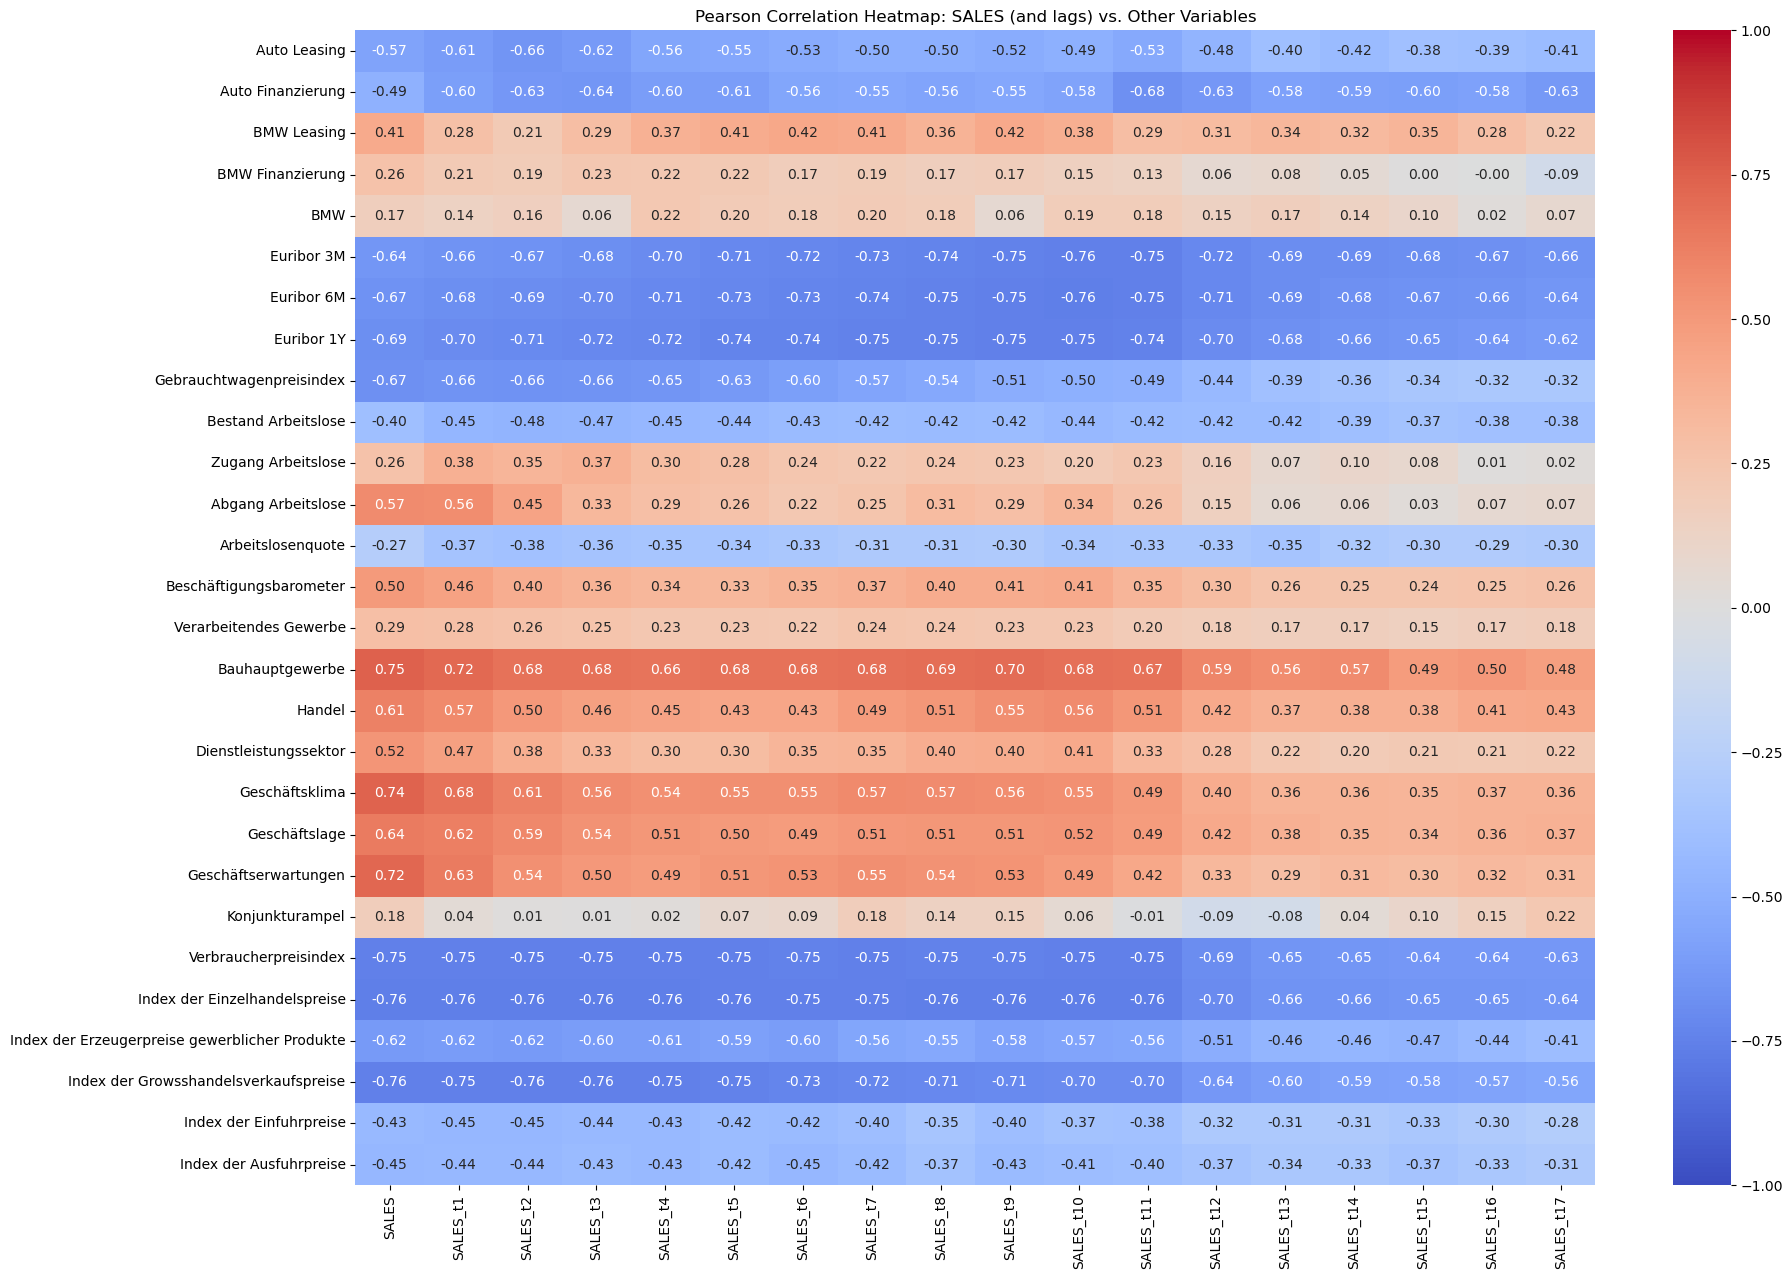


Pearson Correlation Subset:


,SALES,SALES_t1,SALES_t2,SALES_t3,SALES_t4,SALES_t5,SALES_t6,SALES_t7,SALES_t8,SALES_t9,SALES_t10,SALES_t11,SALES_t12,SALES_t13,SALES_t14,SALES_t15,SALES_t16,SALES_t17
Auto Leasing,-0.572034,-0.610040,-0.655299,-0.624450,-0.560658,-0.552850,-0.528604,-0.500787,-0.502736,-0.521836,-0.492884,-0.534475,-0.476067,-0.397177,-0.424591,-0.384136,-0.393076,-0.414613
Auto Finanzierung,-0.486705,-0.597280,-0.634763,-0.642022,-0.603562,-0.607291,-0.556214,-0.551534,-0.563577,-0.552029,-0.575304,-0.677904,-0.633822,-0.583952,-0.589879,-0.595729,-0.581639,-0.629053
BMW Leasing,0.407418,0.277385,0.209011,0.294957,0.367737,0.405983,0.424652,0.413568,0.363537,0.418729,0.384145,0.294844,0.311773,0.343489,0.316180,0.347805,0.283964,0.220503
BMW Finanzierung,0.260801,0.206644,0.191055,0.227112,0.223858,0.215794,0.174504,0.193856,0.167401,0.174973,0.153875,0.133253,0.064608,0.079114,0.049312,0.000470,-0.003709,-0.085960
BMW,0.167463,0.137545,0.158071,0.062923,0.220088,0.202533,0.184812,0.199618,0.180728,0.063420,0.187345,0.184879,0.146837,0.168036,0.137304,0.101017,0.015990,0.071590
Euribor 3M,-0.644080,-0.658463,-0.670844,-0.684170,-0.698423,-0.712660,-0.723251,-0.733555,-0.740911,-0.749106,-0.757109,-0.753753,-0.715002,-0.694229,-0.688422,-0.681478,-0.674090,-0.662022
Euribor 6M,-0.665599,-0.680384,-0.692041,-0.702140,-0.712526,-0.725022,-0.733986,-0.741579,-0.746355,-0.753520,-0.759200,-0.752542,-0.711329,-0.687960,-0.678751,-0.669199,-0.659065,-0.644860
Euribor 1Y,-0.685759,-0.697948,-0.709867,-0.717691,-0.724492,-0.735190,-0.742015,-0.745039,-0.745773,-0.751898,-0.753531,-0.743965,-0.700652,-0.675084,-0.662629,-0.651323,-0.638417,-0.621454
Gebrauchtwagenpreisindex,-0.673200,-0.663046,-0.664895,-0.662978,-0.651300,-0.627538,-0.598744,-0.569117,-0.543227,-0.512744,-0.498139,-0.491919,-0.435749,-0.387511,-0.362490,-0.336894,-0.321423,-0.323595
Bestand Arbeitslose,-0.395794,-0.454093,-0.475070,-0.467192,-0.452690,-0.443158,-0.425914,-0.419829,-0.424263,-0.419600,-0.438755,-0.424670,-0.419530,-0.417154,-0.392686,-0.371082,-0.383886,-0.384244


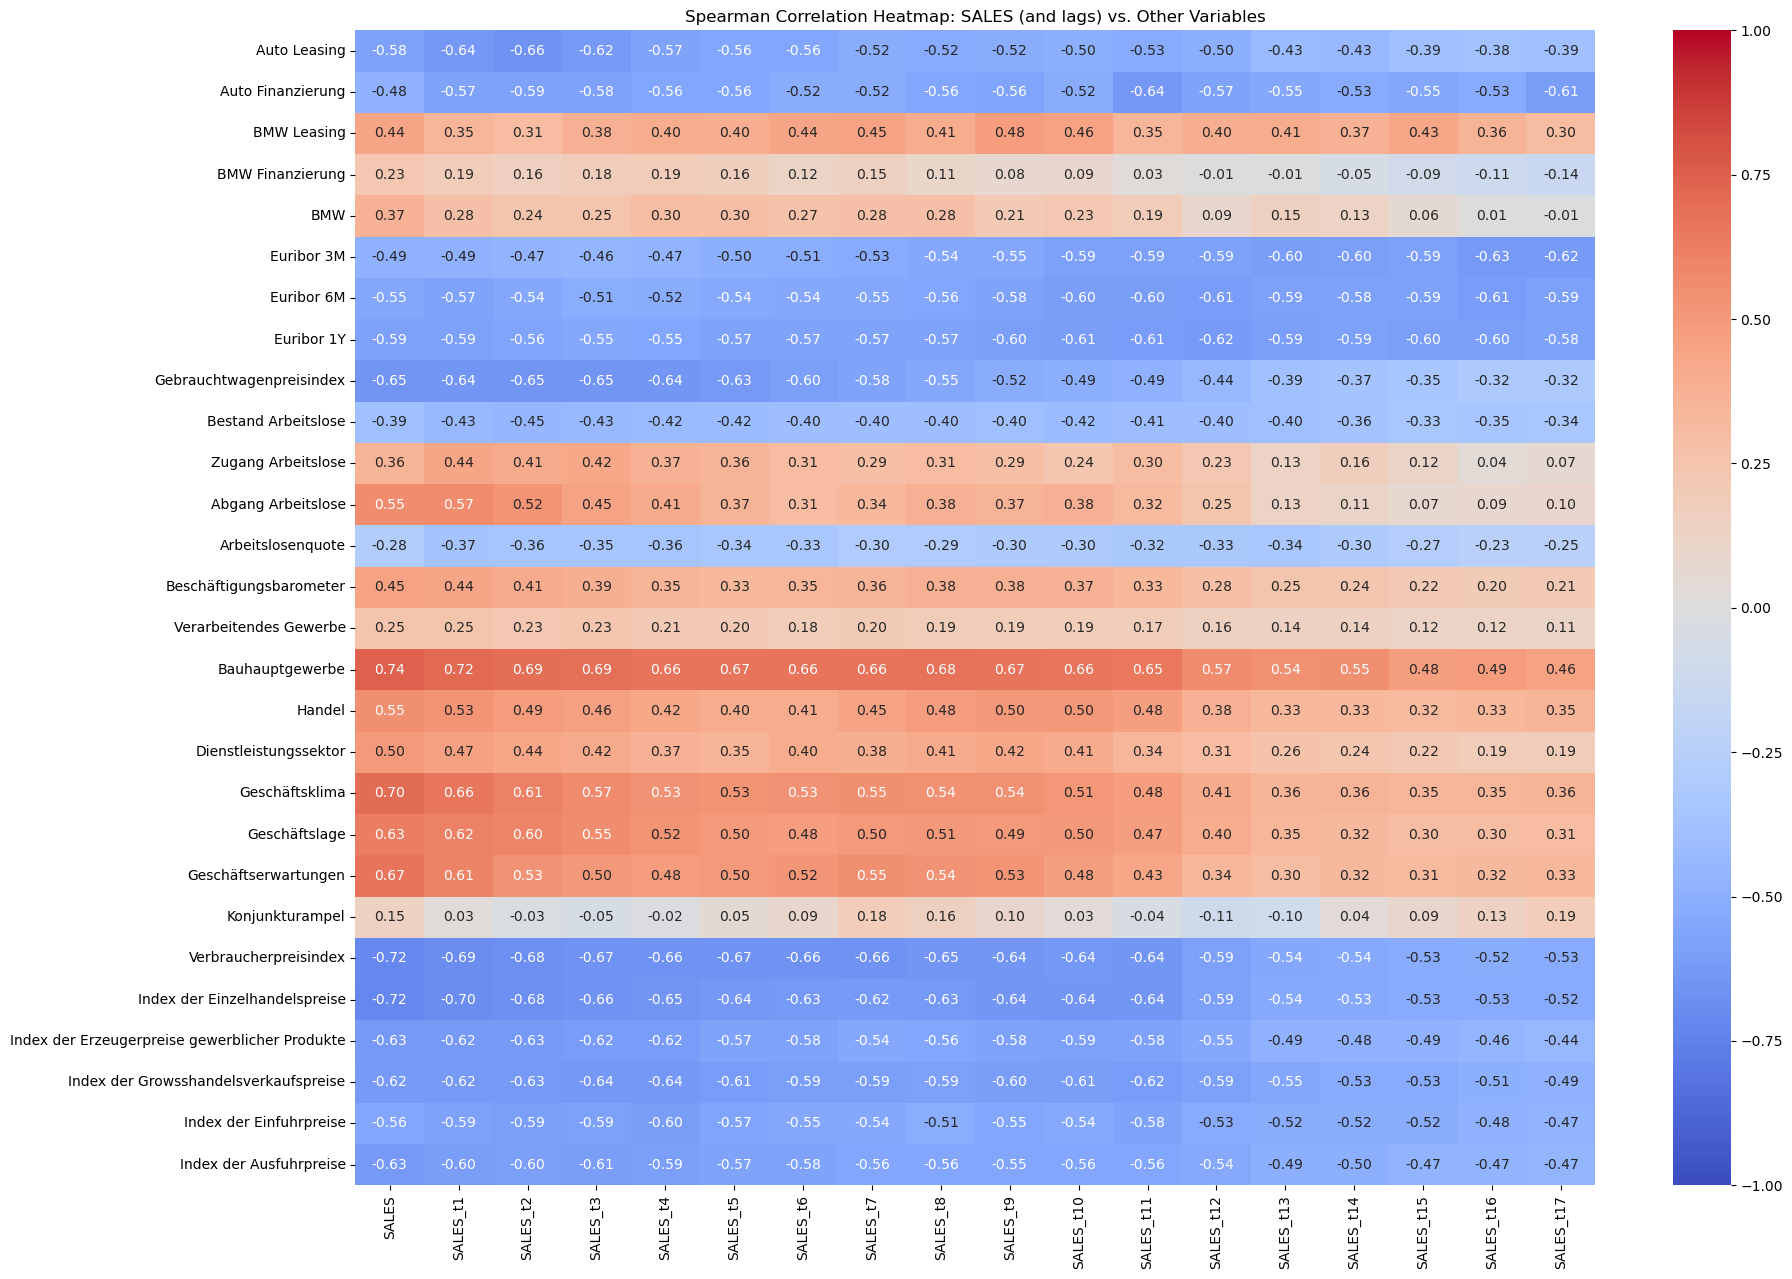


Spearman Correlation Subset:


,SALES,SALES_t1,SALES_t2,SALES_t3,SALES_t4,SALES_t5,SALES_t6,SALES_t7,SALES_t8,SALES_t9,SALES_t10,SALES_t11,SALES_t12,SALES_t13,SALES_t14,SALES_t15,SALES_t16,SALES_t17
Auto Leasing,-0.584543,-0.635563,-0.661132,-0.619957,-0.571112,-0.557515,-0.560444,-0.518251,-0.524001,-0.520200,-0.495974,-0.528194,-0.501225,-0.426674,-0.429887,-0.392092,-0.381571,-0.387674
Auto Finanzierung,-0.482895,-0.571347,-0.585768,-0.583387,-0.556996,-0.555654,-0.519505,-0.517683,-0.556055,-0.564823,-0.518819,-0.636719,-0.573493,-0.545485,-0.527489,-0.547660,-0.526636,-0.605478
BMW Leasing,0.441750,0.347283,0.306609,0.378681,0.404847,0.395100,0.442779,0.446110,0.405886,0.478458,0.456083,0.347274,0.395335,0.405445,0.372255,0.433130,0.362292,0.297821
BMW Finanzierung,0.227738,0.190423,0.163473,0.179089,0.189003,0.164355,0.124091,0.153902,0.107291,0.083426,0.087443,0.031084,-0.009855,-0.014391,-0.047307,-0.090529,-0.109896,-0.143821
BMW,0.370383,0.275064,0.243931,0.253679,0.303366,0.295891,0.267364,0.277445,0.279345,0.210437,0.228286,0.194420,0.088648,0.151463,0.131752,0.057005,0.013735,-0.011961
Euribor 3M,-0.488587,-0.488151,-0.470360,-0.455215,-0.474744,-0.500073,-0.509204,-0.528190,-0.543316,-0.550795,-0.591172,-0.591794,-0.591491,-0.603154,-0.597011,-0.592181,-0.626901,-0.622781
Euribor 6M,-0.548800,-0.570538,-0.539224,-0.508096,-0.518259,-0.536750,-0.540130,-0.551509,-0.560193,-0.575706,-0.604434,-0.603332,-0.611145,-0.593408,-0.583872,-0.585850,-0.611743,-0.590700
Euribor 1Y,-0.590253,-0.591639,-0.564586,-0.547697,-0.554951,-0.570542,-0.573525,-0.572320,-0.574108,-0.596228,-0.608714,-0.614195,-0.620866,-0.593828,-0.591737,-0.598839,-0.596400,-0.583135
Gebrauchtwagenpreisindex,-0.648896,-0.644027,-0.650385,-0.649836,-0.642166,-0.625433,-0.601070,-0.576608,-0.550070,-0.516918,-0.492839,-0.487284,-0.442691,-0.390153,-0.366435,-0.345745,-0.316170,-0.315935
Bestand Arbeitslose,-0.385392,-0.434217,-0.450048,-0.434384,-0.422971,-0.416436,-0.400899,-0.398597,-0.404406,-0.397559,-0.418317,-0.413713,-0.403574,-0.395217,-0.360528,-0.330581,-0.345745,-0.339603


In [35]:
# modeling

# correlation
# Define target columns (SALES and its lags)
target_cols = ['SALES'] + [f'SALES_t{i}' for i in range(1, 18)]

# Define other columns (all columns except DATE and target_cols)
other_cols = [col for col in df_fe.columns if col not in target_cols + ['DATE']]

correlation_methods = ['pearson', 'spearman']

for method in correlation_methods:
    # Calculate the correlation matrix between target_cols and other_cols
    correlation_matrix = df_fe[target_cols + other_cols].corr(method=method)

    # Select the relevant part of the correlation matrix
    # This shows the correlation of each 'other_col' with each 'target_col'
    correlation_subset = correlation_matrix.loc[other_cols, target_cols]

    # Plot the heatmap
    plt.figure(figsize=(20, 15))
    sns.heatmap(correlation_subset, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    plt.title(f'{method.capitalize()} Correlation Heatmap: SALES (and lags) vs. Other Variables')
    plt.show()

    print(f"\n{method.capitalize()} Correlation Subset:")
    display(correlation_subset)

In [ ]:
# indexing
df_sa["DATE"] = pd.to_datetime(df_sa["DATE"])
df_sa = df_sa.set_index("DATE")

columns_to_index = [
    "Absatzzahlen",
    "BMW Finanzierung",
    "BMW Leasing",
    "Auto Finanzierung",
    "Auto Leasing",
    "Gebrauchtwagenindex",
    "Geschäftsklima",
    "Geschäftslage",
    "Geschäftserwartungen",
    "Verbraucherpreisindex",
    "Arbeitslosenquote",
    "Bestand Arbeitslose",
    "Zugang Arbeitslose",
    "Abgang Arbeitslose",
]

In [ ]:
# plotting

In [ ]:
# multiple linear regression analysis

In [ ]:
# regression model